**Testing trained model** - Run with Google Colab

In [1]:
google_drive_path = "gdrive/MyDrive/"
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%tensorflow_version 1.x
import tensorflow as tf
import sys
import pickle
import numpy as np

Mounted at /content/gdrive
TensorFlow 1.x selected.


In [2]:
# !git clone https://github.com/NVlabs/stylegan.git
!ls gdrive/MyDrive/stylegan/
sys.path.insert(0, google_drive_path+"stylegan")
import dnnlib

config.py	 generate_figures.py	__pycache__	     training
datasets	 LICENSE.txt		README.md	     train.py
dataset_tool.py  metrics		run_metrics.py
dnnlib		 pretrained_example.py	stylegan-teaser.png


In [3]:
import dnnlib.tflib as tflib
import PIL.Image
dnnlib.tflib.init_tf()
with open(google_drive_path+"maki_gen.pkl", 'rb') as pickle_file:
  _G, _D, Gs = pickle.load(pickle_file)














Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


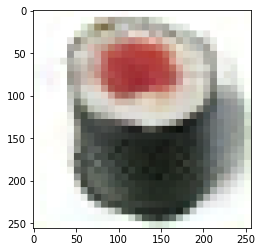

In [4]:
import matplotlib.pyplot as plt
from random import randrange

# Pick latent vector.
rnd = np.random.RandomState(5)
latents = rnd.randn(100, Gs.input_shape[1])

# Generate image.
fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
images = Gs.run(latents, None, truncation_psi=0.7, randomize_noise=True, output_transform=fmt)


plt.imshow(images[randrange(100)])

**Transfer learning StyleGan** - Run with Google Colab

In [ ]:
! python gdrive/MyDrive/stylegan/dataset_tool.py create_from_images gdrive/MyDrive/stylegan/datasets/custom-dataset gdrive/MyDrive/sushi

In [ ]:
! python gdrive/MyDrive/stylegan/train.py

**Custom GAN** - Run in local

In [ ]:
import os, sys, os.path
sys.path.append("/home/paul/Development/Projects/Sushi/")
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import ones_like, train
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg

In [ ]:
image_size = 256 #in pixels
image_depth = 3
input_shape = (image_size, image_size, image_depth)
input_dim = (image_size * image_size * image_depth)
output_dimension = input_dim
latent_dim = 500

**Single images path**

In [ ]:
gan_path = './gan.keras'
disc_path = './disc.keras'
gen_path = './gen.keras'

**Load single image dataset**

In [ ]:
image_paths = [f for f in os.listdir('./sushi')]
X = []
for img_path in image_paths:
    if not img_path == ".ipynb_checkpoints":
        image = mpimg.imread("./sushi/" + img_path)
        image = np.resize(image, input_shape)
        #if image_arr.shape == (image_size, image_size, image_depth):
        X.append(image*2-1)
X = np.array(X)
Y = np.ones(len(X))
X = X.reshape(X.shape[0], image_size, image_size, image_depth).astype('float32')
print(X.shape)

In [ ]:
def generate_latent_points(latent_dim, n_samples):
    latent_points = np.random.randn(latent_dim * n_samples)
    latent_points = latent_points.reshape(n_samples, latent_dim)
    return latent_points

In [ ]:
# define the standalone generator model
def generator_model(latent_dim=100):
    model = keras.Sequential()
    # Starting with (image_size / 4) x (image_size / 4)
    f1 = np.int32(image_size / 4)
    n_nodes = 128 * f1 * f1

    model.add(layers.Dense(int(n_nodes/8), input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(int(n_nodes/4)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(int(n_nodes/2)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(n_nodes))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape((f1, f1, 128)))
    # Here we are in (image_size / 2) x (image_size / 2)
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # Here we are in image_size x image_size
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(image_depth, (7,7), activation='sigmoid', padding='same'))
    
    return model

In [ ]:
def discriminator_model(in_shape=(image_size,image_size,image_depth)):
    model = keras.Sequential()
    model.add(layers.Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(32))
    model.add(layers.Dense(1, activation='sigmoid'))
    # compile model
    opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [ ]:
def train_discriminator(d_model, g_model, latent_dim, dataset, n_iter=10, index=0, n_batch=10):
    for i in range(n_iter):
        # Generate latent points
        x_gan = generate_latent_points(latent_dim, n_batch)
        # Generate images from latent points 
        generated_images = g_model.predict(x_gan).reshape((image_size, image_size, image_depth))
        generated_images = generated_images.reshape(n_batch, image_size, image_size, image_depth)
        # Concatenate our real image and generated images
        X_disc = np.concatenate([dataset[index:(index+n_batch)], generated_images])
        Y_disc = np.concatenate([np.ones(n_batch), np.zeros(n_batch)])

        d_model.fit(X_disc, Y_disc, epochs=1, verbose=1)

In [ ]:
def gan_model(g_model, d_model):
    d_model.trainable = False
    model = keras.Sequential()
    model.add(g_model)
    model.add(d_model)

    opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [ ]:
def train_gan(gan_model, latent_dim, n_iter=10, n_batch=10):
    for i in range(n_iter):
        # Generate latent points
        X = generate_latent_points(latent_dim, n_batch)
        Y = np.ones((n_batch, 1))

        gan_model.fit(X, Y, epochs=1, verbose=1)

In [ ]:
# Initialize our models
d_model = discriminator_model()

g_model = generator_model(latent_dim)
g_model.summary()

#gan_model = gan_model(g_model, d_model)


**Training system**

In [ ]:
epochs = 50
curr_epochs = 0

index = 0
batch_size = 10
index_max = len(X) - batch_size

while curr_epochs < epochs:

    if index > index_max:
        index = index_max
    elif index == index_max:
        index = 0
    
    print("------ Training discriminator ------")
    train_discriminator(d_model, g_model, latent_dim, X, n_iter=10, index=index, n_batch=batch_size)
    
    print("------ Training GAN ------")
    train_gan(gan_model, latent_dim, n_iter=20, n_batch=batch_size*2)
    
    index = index + batch_size
    curr_epochs = curr_epochs + 1
    
    # Save the model every 15 epochs
    if (curr_epochs + 1) % 15 == 0:
        gan_model.save(gan_path)
        d_model.save(disc_path)
        g_model.save(gen_path)
    
    print("------ Adv. " + str(curr_epochs) + "/" + str(epochs) + " ------")

In [ ]:
# Save models
gan_model.save(gan_path)
d_model.save(disc_path)
g_model.save(gen_path)

**Test prediction**

In [ ]:
#Load models
gan_model = keras.models.load_model(gan_path)
d_model = keras.models.load_model(disc_path)
g_model = keras.models.load_model(gen_path)

In [ ]:
x_gan = generate_latent_points(latent_dim, 1)
gen_image = g_model.predict(x_gan).reshape((image_size, image_size, image_depth))
plt.imshow(gen_image)